# Assessment 2: CNNs for image classification

In [27]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [31]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [29]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\cuda\memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


## Step01: Data exploration

In [32]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

Qlib data is not found in ~/.qlib/qlib_data/us_data


2023-11-14 17:58:52.888 | WARNING  | qlib.tests.data:download_data:80 - The data for the example is collected from Yahoo Finance. Please be aware that the quality of the data might not be perfect. (You can refer to the original data source: https://finance.yahoo.com/lookup.)
2023-11-14 17:58:52.888 | INFO     | qlib.tests.data:download_data:82 - qlib_data_us_1d_latest.zip downloading......
450095104it [06:18, 1189699.08it/s]                               
2023-11-14 18:05:11.224 | WARNING  | qlib.tests.data:_unzip:105 - will delete the old qlib data directory(features, instruments, calendars, features_cache, dataset_cache): C:\Users\possa\.qlib\qlib_data\us_data
2023-11-14 18:05:11.231 | INFO     | qlib.tests.data:_unzip:108 - C:\Users\possa\.qlib\qlib_data\us_data\20231114175851_qlib_data_us_1d_latest.zip unzipping......
100%|██████████| 71959/71959 [01:34<00:00, 765.25it/s]
[20840:MainThread](2023-11-14 18:06:46,322) INFO - qlib.Initialization - [config.py:416] - default_conf: client

In [121]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
index_list  = ['AAPL', 'MSFT']
index_name  = ['Apple', 'Microsoft']
fields = ['$close', '$volume', '$open', '$high', '$low']
fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
stocks_df = D.features(index_list , fields, freq='day')
stocks_df

$close       $volume     $open     $high      $low
instrument datetime                                                        
AAPL       1999-12-31  1.000000  1.503736e+08  0.981763  1.000608  0.967781
           2000-01-03  1.088754  4.918448e+08  1.020061  1.094225  0.989058
           2000-01-04  0.996960  4.703467e+08  1.052887  1.075988  0.984194
           2000-01-05  1.011550  7.144751e+08  1.009118  1.075380  1.001823
           2000-01-06  0.924012  7.049752e+08  1.032219  1.040729  0.924012
...                         ...           ...       ...       ...       ...
MSFT       2020-11-04  5.807628  1.576521e+09  5.744020  5.859427  5.701078
           2020-11-05  5.992815  1.344331e+09  5.959267  6.015091  5.935380
           2020-11-06  6.004356  9.401309e+08  5.965171  6.021533  5.851644
           2020-11-09  5.861306  1.654141e+09  6.023680  6.122446  5.847618
           2020-11-10  5.663236  1.641103e+09  5.756903  5.810580  5.628614

[10500 rows x 5 columns]

### Exploratory Image analysis

In [122]:
df = index_data.reset_index()
df = df.set_index('datetime')
df

,instrument,$close,$volume,$open,$high,$low
datetime,,,,,,
1999-12-31,AAPL,1.000000,1.503736e+08,0.981763,1.000608,0.967781
2000-01-03,AAPL,1.088754,4.918448e+08,1.020061,1.094225,0.989058
2000-01-04,AAPL,0.996960,4.703467e+08,1.052887,1.075988,0.984194
2000-01-05,AAPL,1.011550,7.144751e+08,1.009118,1.075380,1.001823
2000-01-06,AAPL,0.924012,7.049752e+08,1.032219,1.040729,0.924012
...,...,...,...,...,...,...
2020-11-04,MSFT,5.807628,1.576521e+09,5.744020,5.859427,5.701078
2020-11-05,MSFT,5.992815,1.344331e+09,5.959267,6.015091,5.935380
2020-11-06,MSFT,6.004356,9.401309e+08,5.965171,6.021533,5.851644


1
2


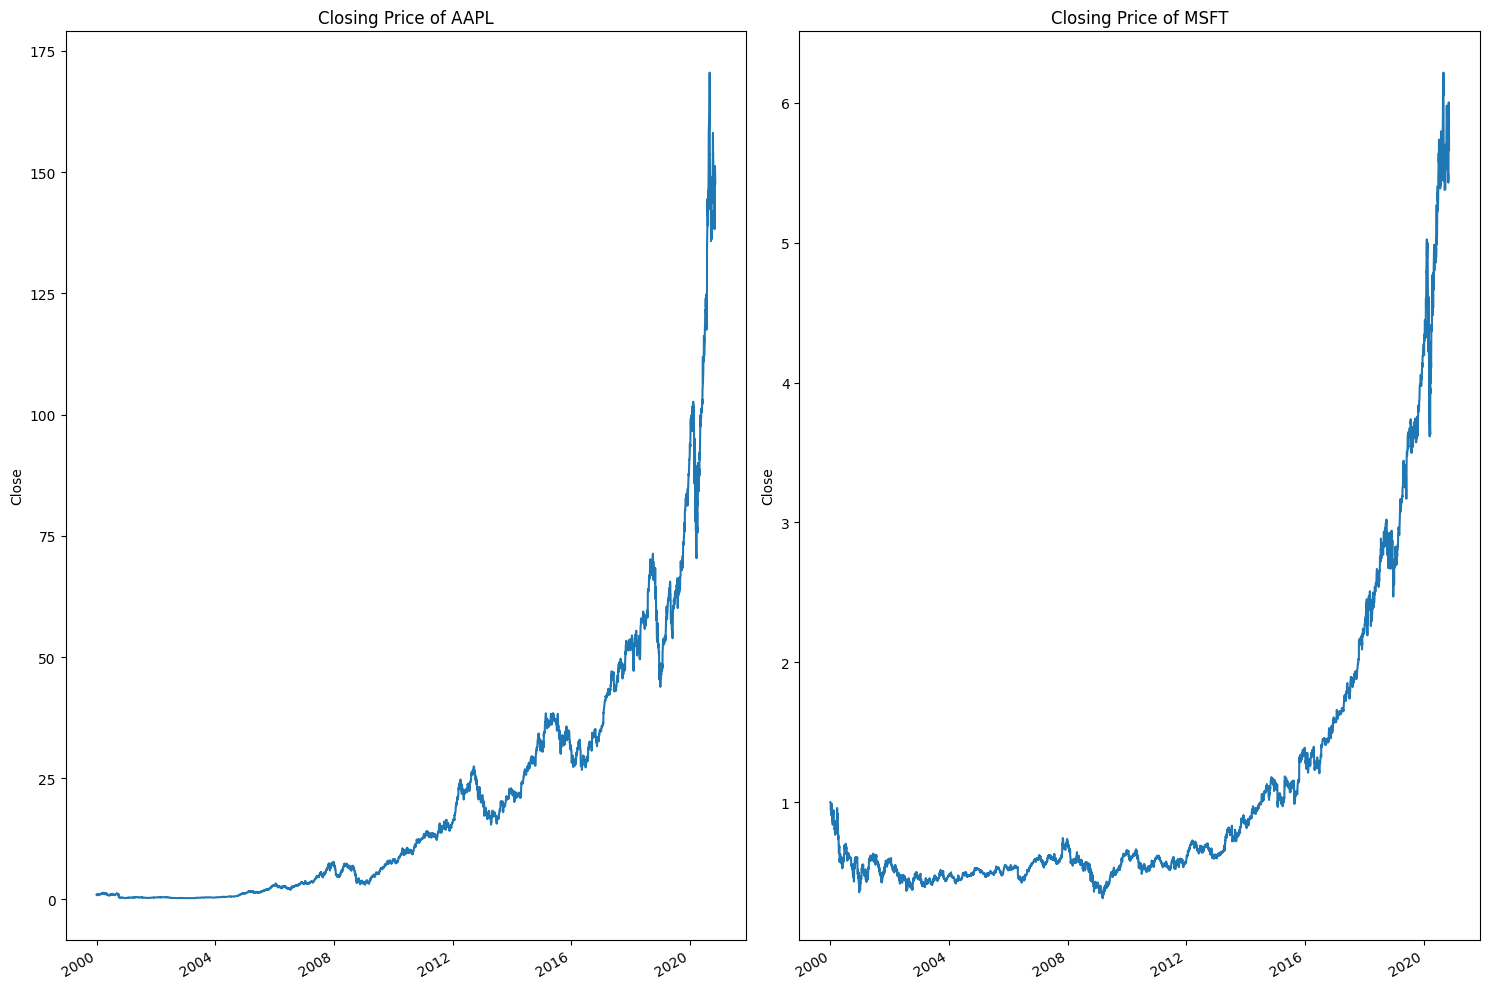

In [123]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(index_name, 1):
    print(i)
    plt.subplot(1, 2, i)
    df.loc[df['instrument'] == index_list[i-1]]['$close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {index_list[i - 1]}")
    
plt.tight_layout()

## Step 3: Data Preprocessing

In [124]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
stocks_data_scaled = scaler.fit_transform(stocks_df)
stocks_data_scaled

array([[0.00437381, 0.00423312, 0.00417523, 0.00424891, 0.00434857],
       [0.00489503, 0.01557725, 0.00439456, 0.00478353, 0.00447701],
       [0.00435596, 0.01486306, 0.00458255, 0.00467938, 0.00444765],
       ...,
       [0.03376257, 0.03046992, 0.03271419, 0.03292195, 0.03383157],
       [0.03292249, 0.05419028, 0.03304925, 0.03349824, 0.03380727],
       [0.03175929, 0.05375717, 0.03152148, 0.03171726, 0.03248518]],
      dtype=float32)

In [125]:
train_size = int(len(stocks_data_scaled) * 0.7)
valid_size = int(len(stocks_data_scaled) * 0.2)
train_data = stocks_data_scaled[:train_size]
valid_data = stocks_data_scaled[train_size:train_size + valid_size]
test_data = stocks_data_scaled[train_size + valid_size:]

In [126]:
# # Normalize your data
# # Here you should write the normalization logic. It's a placeholder.
# normalized_data = df.reset_index()
# normalized_data = normalized_data.set_index(['instrument','datetime'])
# normalized_data = (normalized_data - normalized_data.mean()) / normalized_data.std()
# normalized_data = normalized_data.reset_index()
# normalized_data = normalized_data.set_index(['datetime'])
# normalized_data

## Step 4: Define the RNN Model

In [127]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [128]:
import torch
import torch.nn as nn

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = StockRNN(input_size=5, hidden_size=10, num_layers=2)

## training model

In [129]:
criterion = nn.MSELoss()
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (pseudo-code)
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(train_data)
    targets = ...

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

IndexError: too many indices for tensor of dimension 2

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1
model = NaturalSceneClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

### 6. Evaluation with Testing Set